In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
# additional imports needed
from nltk.probability import FreqDist
import spacy

In [2]:
# custom function for preprocessing texts
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()

    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm

    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
    return processed_texts

# Exploration & Cleaning

In [10]:
# Loading in film review data
df = pd.read_csv("Data/NLP/movie_reviews_v2.csv")
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0


In [11]:
df.shape

(8650, 6)

In [12]:
# We have 8650 reviews. Checking for nulls and duplicates
df.info()
print(f'Duplicate count: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB
Duplicate count: 0


In [13]:
# Dropping duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [18]:
# We have a considerable chunk of reviews (1196) without ratings. If we impute values, it could distort predictions a lot.
# Dropping null rows
df = df.dropna(how='any', axis=0)
df.isna().sum().sum()

0

In [19]:
df.head()

,original_title,review,rating
0,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
1,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
2,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
3,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
4,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0


In [20]:
df.describe()

,rating
count,7454.000000
mean,6.497854
std,2.159961
min,0.500000
25%,5.000000
50%,7.000000
75%,8.000000
max,10.000000


In [17]:
# Our objective is to correlate rating with what's written in reviews.
df = df.drop(columns = ['review_id','movie_id','imdb_id'])
df.head()

,original_title,review,rating
0,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
1,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
2,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
3,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
4,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0


In [21]:
# Expanding col width to better read reviews
pd.set_option('display.max_colwidth', 300)
df.head()

,original_title,review,rating
0,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0
1,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
2,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0
3,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0
4,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0


# Preprocessing

In [22]:
# we want to capture high and low reviews, leaving middling ones out.
# Setting up filters
filter_h = df['rating'] >= 9.0
filter_l = df['rating'] <= 4.0
# Checking our data balance
filter_h.sum(), filter_l.sum()

(1195, 1224)

In [23]:
# We can use spacy to make a tokens columns using appropriate components
nlp_light = spacy.load("en_core_web_sm", disable=['parse','ner'])
# Print active components
nlp_light.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']

In [24]:
# using custom function to preprocess our text column into tokens. Stopwords are removed by default
df['tokens'] = batch_preprocess_texts(df['review'], nlp = nlp_light)
df.head()

7454it [01:35, 78.29it/s] 


,original_title,review,rating,tokens
0,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loose, ends, long, friendship, develops, usually, nood..."
1,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]"
2,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, ★, ★, ★, liked, personally, recommend]"
3,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, truly, flies, course, looks, relatively, terrific, imp..."
4,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngold, williams, bernstein, adding, super, stop, motion, animation, ray, harryhause..."


In [25]:
# batch preprocess the text and store lemmas
df['lemmas'] = batch_preprocess_texts(df['review'], nlp = nlp_light, use_lemmas = True)
df.head()

7454it [01:41, 73.51it/s] 


,original_title,review,rating,tokens,lemmas
0,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loose, ends, long, friendship, develops, usually, nood...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en..."
1,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]"
2,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, ★, ★, ★, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]"
3,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, truly, flies, course, looks, relatively, terrific, imp...","[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly, fly, course, look, relatively, terrific, impress, pac..."
4,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngold, williams, bernstein, adding, super, stop, motion, animation, ray, harryhause...","[ok, huge, temptation, riddle, review, pun, go, crack, little, family, adventure, seemingly, base, range, classic, movie, great, escape, star, trek, love, story, score, cann

In [26]:
# Join list of tokens into a string with spaces between each token
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x))
# Join list of lemmas into a string with spaces between each lemma
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head(3)

,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined
0,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loose, ends, long, friendship, develops, usually, nood...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops usually noodles entirely platonic relationship so...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...
1,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, ★, ★, ★, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating ★ ★ ★ liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend


In [27]:
# Make a single giant string with entire group of high review lemmas
high_lemmas = " ".join(df.loc[filter_h, 'lemmas-joined'])
# Make a single giant string with entire group of low review lemmas
low_lemmas= " ".join(df.loc[filter_l, 'lemmas-joined'])

In [28]:
# Saving dataframe in our NLP folder as joblib
reviews = df.copy()
import joblib
joblib.dump(reviews, "Data/NLP/reviews.joblib")

['Data/NLP/reviews.joblib']

# EDA and Visualization

## Word Clouds

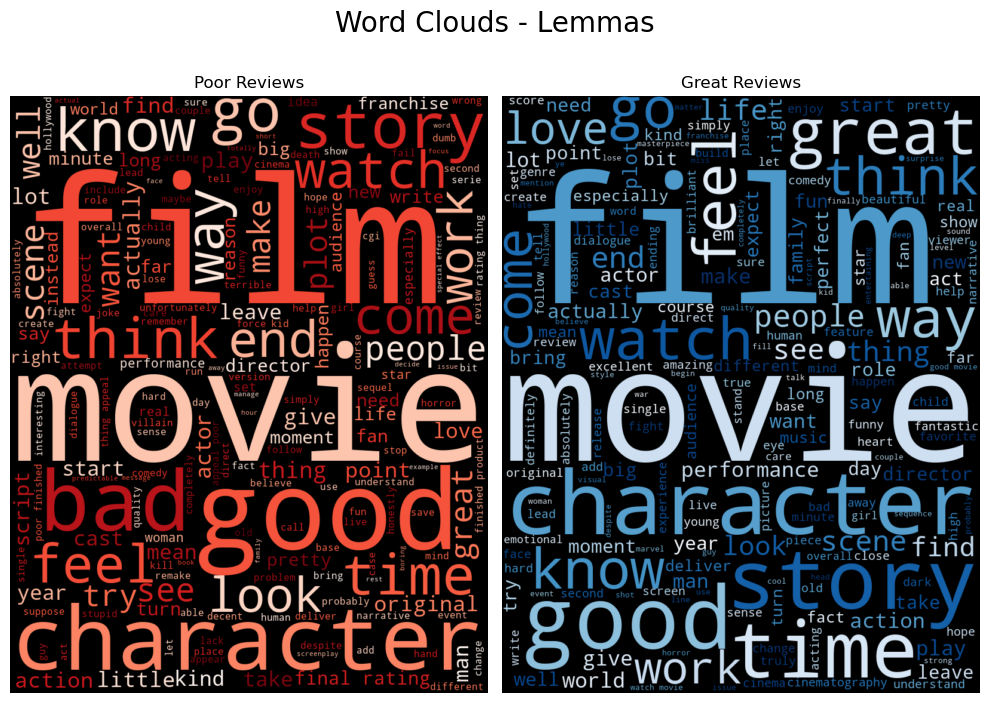

In [29]:
# We'll begin with word clouds of high and low reviews
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
#                      stopwords = custom_stopwords
                     ).generate(low_lemmas)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
#                       stopwords = custom_stopwords
                      ).generate(high_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Poor Reviews")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("Great Reviews")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.05);

In [34]:
# From here, some obvious stopwords stick out to remove
custom_stopwords = ['film', 'movie', 'watch', 'think', 'know', 'good', 'like', 'time']

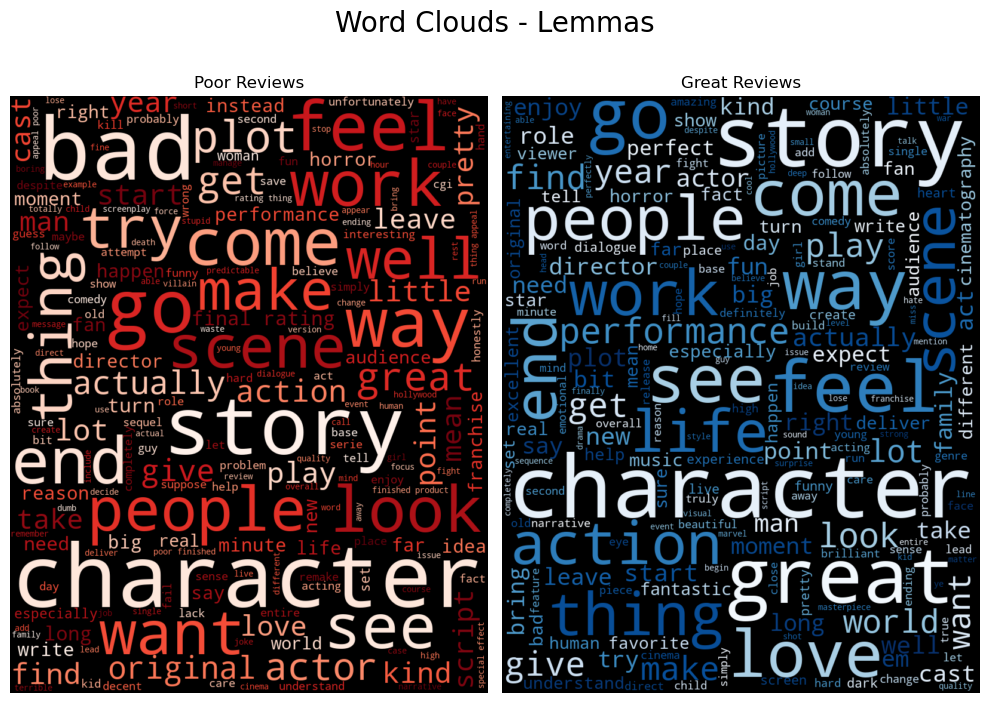

In [35]:
# Making another two clouds with custom stopwords removed
# We'll begin with word clouds of high and low reviews
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                      stopwords = custom_stopwords
                     ).generate(low_lemmas)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
                       stopwords = custom_stopwords
                      ).generate(high_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Poor Reviews")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("Great Reviews")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.05);

### There appears a big vocabulary parallel with positive and negative reviews so far. Character, story and people recur frequently.

In [36]:
# Saving cloud images
low_cloud.to_file('Data/Images/low_cloud.png')
high_cloud.to_file('Data/Images/high_cloud.png')

## Frequency Distribution

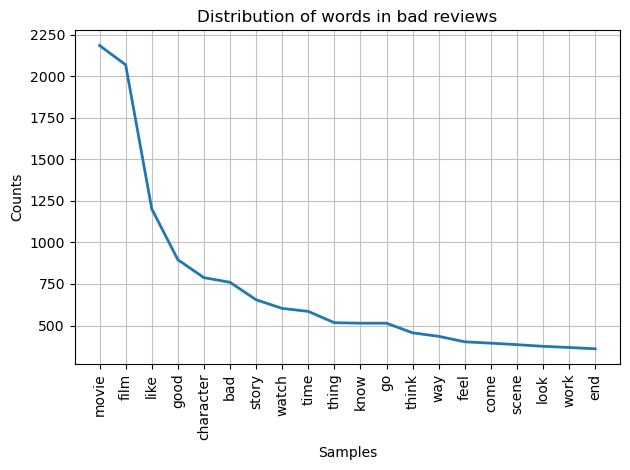

In [37]:
# Split the lemmas into individual token words
low_lemmas_split = low_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
low_dist = FreqDist(low_lemmas_split)
ax = low_dist.plot(20, show = False, title='Distribution of words in bad reviews')
plt.tight_layout()
plt.savefig('Data/Images/low_freq_dist.png');

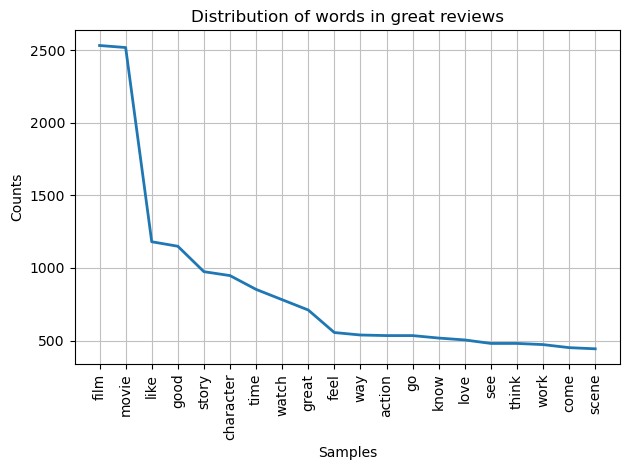

In [38]:
# Split the lemmas into individual token words
high_lemmas_split = high_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
high_dist = FreqDist(high_lemmas_split)
ax = high_dist.plot(20, show=False, title='Distribution of words in great reviews')
plt.tight_layout()
plt.savefig('Data/Images/high_freq_dist.png');

## Ngrams

In [39]:
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

In [41]:
# Make a single giant string with entire group of 5 star tokens
high_reviews_tokens = " ".join(df.loc[filter_h, 'tokens-joined'])
# Make a single giant string with entire group of 1 star tokens
low_reviews_tokens = " ".join(df.loc[filter_l, 'tokens-joined'])

In [45]:
# Split single string into individual list elements
high_reviews_tokens_split = high_reviews_tokens.split()
high_reviews_tokens_split[0:5]

['guilty', 'pleasure', 'personally', 'love', 'great']

In [46]:
# Split single string into individual list elements
low_reviews_tokens_split = low_reviews_tokens.split()
low_reviews_tokens_split[0:5]

['underwhelmed', 'straight', 'bored', 'course', 'seeing']

In [47]:
# Obtain single list of tokens from all high reviews
high_reviews_tokens_exploded_list = df.loc[filter_h, 'tokens'].explode().astype(str).to_list()
high_reviews_tokens_exploded_list[:5]

['guilty', 'pleasure', 'personally', 'love', 'great']

In [48]:
# Obtain single list of tokens from all 1 star reviews
low_reviews_tokens_exploded_list = df.loc[filter_l, 'tokens'].explode().astype(str).to_list()
low_reviews_tokens_exploded_list[:5]

['underwhelmed', 'straight', 'bored', 'course', 'seeing']

In [52]:
# Test the function to find frequency values for quad-grams in low reviews
high_ngram = get_ngram_measures_finder(high_reviews_tokens_exploded_list, ngrams=2, top_n=20)
high_ngram

,Words,Raw Freq
0,"(comic, book)",0.000436
1,"(special, effects)",0.000436
2,"(star, wars)",0.000394
3,"(sci, fi)",0.000358
4,"(feel, like)",0.000351
5,"(action, movie)",0.000343
6,"(watch, movie)",0.000315
7,"(john, wick)",0.000308
8,"(real, life)",0.000308
9,"(long, time)",0.000301


In [53]:
low_ngram = get_ngram_measures_finder(low_reviews_tokens_exploded_list, ngrams=2, top_n=20)
low_ngram

,Words,Raw Freq
0,"(final, rating)",0.001128
1,"(rating, ★)",0.001128
2,"(★, ★)",0.001031
3,"(finished, product)",0.000846
4,"(appeal, poor)",0.000837
5,"(poor, finished)",0.000837
6,"(things, appeal)",0.000837
7,"(★, things)",0.000837
8,"(special, effects)",0.000644
9,"(feels, like)",0.000538


In [56]:
ngram_df = pd.concat([high_ngram, low_ngram], keys=['high reviews', 'low reviews'], axis=1)
ngram_df

high reviews                        low reviews          
                  Words  Raw Freq                    Words  Raw Freq
0         (comic, book)  0.000436          (final, rating)  0.001128
1    (special, effects)  0.000436              (rating, ★)  0.001128
2          (star, wars)  0.000394                   (★, ★)  0.001031
3             (sci, fi)  0.000358      (finished, product)  0.000846
4          (feel, like)  0.000351           (appeal, poor)  0.000837
5       (action, movie)  0.000343         (poor, finished)  0.000837
6        (watch, movie)  0.000315         (things, appeal)  0.000837
7          (john, wick)  0.000308              (★, things)  0.000837
8          (real, life)  0.000308       (special, effects)  0.000644
9          (long, time)  0.000301            (feels, like)  0.000538
10               (<, >)  0.000293                   (★, ½)  0.000529
11       (best, movies)  0.000279        (avoid, possible)  0.000511
12        (spider, man)  0.000272  (boring, disappointing)  0.000511
13   (science, fiction)  0.000258   (disappointing, avoid)  0.000511
14        (best, films)  0.000250              (½, boring)  0.000511
15               (★, ★)  0.000250         (final, rating:)  0.000502
16        (good, movie)  0.000243             (rating:, ★)  0.000502
17      (spoiler, free)  0.000243            (looks, like)  0.000406
18  (action, sequences)  0.000236            (good, movie)  0.000353
19         (felt, like)  0.000229             (star, wars)  0.000353

### High reviews seem to list the specific film franchises and movie types. Poor reviews talk ratings, things, product and such with little mention of genre or franchise

In [58]:
# Making markdown of ngram dataframe
ngram_table = ngram_df.head(20).to_markdown(index=False)
print(ngram_table)

| ('high reviews', 'Words')   |   ('high reviews', 'Raw Freq') | ('low reviews', 'Words')    |   ('low reviews', 'Raw Freq') |
|:----------------------------|-------------------------------:|:----------------------------|------------------------------:|
| ('comic', 'book')           |                    0.000436441 | ('final', 'rating')         |                   0.00112837  |
| ('special', 'effects')      |                    0.000436441 | ('rating', '★')             |                   0.00112837  |
| ('star', 'wars')            |                    0.000393512 | ('★', '★')                  |                   0.0010314   |
| ('sci', 'fi')               |                    0.000357738 | ('finished', 'product')     |                   0.000846277 |
| ('feel', 'like')            |                    0.000350583 | ('appeal', 'poor')          |                   0.000837462 |
| ('action', 'movie')         |                    0.000343429 | ('poor', 'finished')        |                 

## Sentiment Analysis

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [60]:
# Add sentiment scores to the reviews df
df['sentiment_scores'] = df['review'].map(sia.polarity_scores)
# Convert the column of dictionaries into separate columns
df_scores = df['sentiment_scores'].apply(pd.Series)
# Join the new DataFrame with the original DataFrame
reviews = pd.concat([df, df_scores], axis=1).drop('sentiment_scores', axis=1)
reviews.head(1)

,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined,neg,neu,pos,compound
0,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loose, ends, long, friendship, develops, usually, nood...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops usually noodles entirely platonic relationship so...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...,0.068,0.744,0.188,0.9908


In [61]:
# Define filter for positive reviews
pos_sentiment_reviews = reviews['compound'] > 0
pos_sentiment_reviews.sum()

5750

In [62]:
# Identify reviews with a positive sentiment score that received 1 star
filter_mismatch_A = (reviews['rating'] <= 4.0) & pos_sentiment_reviews
pos_sent_low = reviews.loc[filter_mismatch_A,['review','rating','compound']]
pos_sent_low.head()

,review,rating,compound
72,"WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r\nDescription:\r\nThree college students base their class project around gossip and how fast it spreads, which soon spirals out of control.\r\n\r\nReview:\r\nGossip is a Dramatic Thriller that was made fifteen years too late. The story sounds like so...",4.0,0.8695
111,"Pretty typical movie from the early aughts with attractive twenty-somethings in the leads and bland ""rock"" pop music, alongside an overly dramatic score. The acting is so-so at best and really bad story to go along with a laughable ending. Led to two direct-to-video sequels that I'm really not t...",4.0,0.6523
125,"**An excuse to make a film full of women swaying seductively without a hint of softcore.**\r\n\r\nWhat can we say about a romantic film, with light touches of comedy, that spends most of its time showing us very attractive women in tight, short clothes, and bouncing around sensually in an atmosp...",3.0,0.9967
132,"After writing three high-praise reviews, I tried to think of the worst movie that I'd ever sat through and this movie came to mind, front and center. I've sat through plenty of ""chick flicks"" but even by chick flick standards this one is just horrible. (to give this a more modern reference, I ra...",1.0,0.9408
148,"I remember loving this film as a kid. Rewatching the film as an adult, the film does not hold up. I really remember the third act of the film before rewatching the film and it is going to be the only thing I will remember about the film. There are two fun scenes in my opinion: the ending and Cru...",4.0,0.7845


### Positive sentiments may be boosted by catchphrases in otherwise negative reviews, such as "GREAT CAST", "attractive women", "high-praise" and "fun scenes"

In [64]:
# Identify 5 star reviews with negative sentiment
filter_mismatch_B = (reviews['rating'] >= 9.0) & ~pos_sentiment_reviews
reviews.loc[filter_mismatch_B,['review','rating','compound']].head()

,review,rating,compound
22,"One of those few movies that most people don't care for, but I personally think is **criminally** underrated.\r\n\r\n_Final rating:★★★★½ - Ridiculously strong appeal. I can’t stop thinking about it._",9.0,-0.3391
59,"Dazzling Björk in this indictment against the death sentence, in tight close-ups. This film is a UFO, musical without being.",10.0,-0.5574
75,"Shattering expose of the fallible human condition.\r\n\r\nWhat to say about Darren Aronofsky's Requiem for a Dream that hasn't been said already? Without doubt it's a film, that in spite of its high standing on the main movie sites, polarises opinions. It's a film that in simple terms follows fo...",9.0,-0.7907
117,"I'll see you soon!\r\n\r\nBefore taking off for Paris, Alex Browning has a vision that the plane is going to explode. Pannicking he gets off the plane and in the mêlée a teacher and a group of his class mates are forced off the flight, the plane goes on to explode in mid air, killing everyone on...",9.0,-0.9920
254,"There can't be such devils out there. \r\n\r\nThe Pledge is directed by Sean Penn and adapted to screenplay by Jerzy Kromolowski and Mary Olson-Kromolowski from Friedrich Dürrenmatt's novel, ""The Promise"". It stars Jack Nicholson, Robin Wright Penn, Aaron Eckhart, Sam Shepard, Patricia Clarkson,...",9.0,-0.9755


### Like the negative reviews, catchphrases turn the balance like "most people don't care for" and "death sentence". Of note also is reviewers writing synapses of the plots' exciting parts and character quotes which in isolation may be interpreted negative. Sentiment analysis may not understand context this far yet.

# Reflection

## Were one to make a successful movie, there could be some lessons to extrapolate here:
1. Story and character are frequently brought up in reviews, positive and negative. Make them memorable not formulaic.
2. Based on our bigrams, reviewers appreciate films true to their genres (action, sci fi). Boring and not being finished recur for negatives.
3. Positive reviews quote characters and scenes while negative reviews emphasize the films' forgettability.

## Credits
### This product uses the TMDB API but is not endorsed or certified by TMDB.

![TMDB](https://www.themoviedb.org/assets/2/v4/logos/v2/blue_short-8e7b30f73a4020692ccca9c88bafe5dcb6f8a62a4c6bc55cd9ba82bb2cd95f6c.svg)